# Building a Product Recommendation System

## Introduction
In this notebook, we will build a product recommendation system using both popularity-based and collaborative filtering methods. We'll be working with a dataset of user ratings for electronic products, and we'll explore how different recommendation techniques can help us suggest products to users. By the end of this notebook, we will have built a simple but effective recommendation engine that can suggest products to users based on their past behavior and the behavior of other users.

# 1. Importing Libraries
First, we'll import all the necessary libraries that we'll use throughout the notebook. These include libraries for data manipulation, mathematical computations, and data visualization.

In [1]:
# Import necessary libraries for data manipulation, mathematical operations, and visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis
import math  # For mathematical operations
import json  # For working with JSON data
import time  # For tracking execution time
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For advanced data visualization
from sklearn.metrics.pairwise import cosine_similarity  # For measuring similarity between vectors
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.neighbors import NearestNeighbors  # For nearest neighbors algorithm
import joblib  # For saving and loading models
import scipy.sparse  # For working with sparse matrices
from scipy.sparse import csr_matrix  # For creating compressed sparse row matrices
from scipy.sparse.linalg import svds  # For performing Singular Value Decomposition (SVD)
import warnings; warnings.simplefilter('ignore')  # To suppress warnings

%matplotlib inline 

## 2. Loading and Exploring the Dataset
We will load the dataset, give appropriate column names, and drop unnecessary columns. We will also explore the data to understand its structure.

In [2]:
# Importing the dataset and assigning column names
columns = ['userId', 'productId', 'ratings', 'timestamp']
electronics_df = pd.read_csv('data/rating_electronics.csv', names=columns)
electronics_df.head()  # Displaying the first few rows of the dataset

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
# Dropping the 'timestamp' column as it is not required for the recommendation system
electronics_df.drop('timestamp', axis=1, inplace=True)
electronics_df.info()  # Displaying information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [4]:
# Checking the number of rows and columns in the dataset
rows, columns = electronics_df.shape
print('Number of rows: ', rows)
print('Number of columns: ', columns)

Number of rows:  7824482
Number of columns:  3


In [5]:
# Checking the data types of each column
electronics_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

## 3. Data Preprocessing and Subsetting
Since the dataset is large, we'll take a subset of the data for quicker processing. We'll also explore the distribution of ratings and check for missing values.

In [6]:
# Taking a subset of the dataset for quicker processing and analysis
electronics_df1 = electronics_df.iloc[:60000, :]

In [7]:
# Displaying information about the subset of the dataset
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     60000 non-null  object 
 1   productId  60000 non-null  object 
 2   ratings    60000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.4+ MB


In [8]:
# Summary statistics of the 'ratings' column
electronics_df1['ratings'].describe().transpose()

count    60000.000000
mean         4.052350
std          1.338559
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

In [9]:
# Finding the minimum and maximum ratings
print('Minimum rating is: %d' % (electronics_df1.ratings.min()))
print('Maximum rating is: %d' % (electronics_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


The Rating is thus on a scale from 1 to 5.

In [10]:
# Checking for missing values in the dataset
print('Number of missing values across columns: \n', electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


There are no missing values.

## 4. Visualizing the Rating Distribution
We'll visualize the distribution of ratings to understand how users have rated products. This helps us get a sense of the overall sentiment in the dataset.

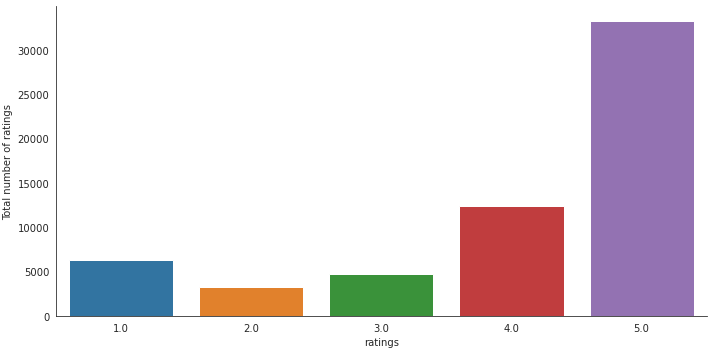

In [11]:
# Plotting the distribution of ratings
with sns.axes_style('white'):
    g = sns.catplot(x="ratings", data=electronics_df1, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")

Least number of least have rated 2 and most number of users have rated 5.

## 5. Identifying Unique Users and Products
We'll explore the number of unique users and products in the dataset, and identify the top users based on the number of ratings they have given.

In [12]:
# Checking the number of unique users and products in the dataset
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
print('Number of unique products in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  55334
Number of unique products in Raw data =  4140


In [13]:
# Displaying the top 10 users based on the number of ratings they have given
most_rated = electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n', most_rated)

Top 10 users based on ratings: 
 userId
A231WM2Z2JL0U3    45
AY8Q1X7G96HV5     34
A2BGZ52M908MJY    33
A1NVD0TKNS1GT5    25
A3MEIR72XKQY88    22
A1MJMYLRTZ76ZX    22
A1RPTVW5VEOSI     22
ALUNVOQRXOZIA     21
A243HY69GIAHFI    20
A6FIAB28IS79      17
dtype: int64


## 6. Filtering Data for Collaborative Filtering
We will filter the data to include only users who have rated a minimum number of products. This helps in building a denser user-item matrix for collaborative filtering.

In [14]:
# Filtering users who have rated 15 or more products
counts = electronics_df1.userId.value_counts()
electronics_df1_final = electronics_df1[electronics_df1.userId.isin(counts[counts >= 15].index)]
print('Number of users who have rated 25 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 25 or more items = 324
Number of unique users in the final data =  14
Number of unique products in the final data =  14


This dataframe has users who have rated 25 items or more.

## 7. Creating a User-Item Matrix
We'll construct a user-item matrix that we will use for our recommendation models.

In [15]:
# Constructing the user-item matrix (pivot table) with users as rows and products as columns
final_ratings_matrix = electronics_df1_final.pivot(index='userId', columns='productId', values='ratings').fillna(0)
final_ratings_matrix.head()

productId,1400599997,B00000DM9M,B00000J05A,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1UQ,B00000J1US,...,B00004WCIA,B00004WEJX,B00004WGNF,B00004WHEX,B00004WHEZ,B00004WHF0,B00004WHF1,B00004WHF4,B00004WHF9,B00004WHIL
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0


This is a very sparse matrix.

In [16]:
# Displaying the shape of the user-item matrix
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (14, 274)


There are 14 products and 274 users.

In [17]:
# Calculating the density of the user-item matrix (percentage of non-zero entries)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
density = (given_num_of_ratings / possible_num_of_ratings) * 100
print('Density: {:4.2f}%'.format(density))

Density: 8.45%


This also shows the sparsity of the matrix.

## 8. Splitting the Data
We will split the data into training and testing sets to evaluate our recommendation models.

In [18]:
# Splitting the dataset into training and testing sets (70:30 ratio)
train_data, test_data = train_test_split(electronics_df1_final, test_size=0.3, random_state=0)
train_data.head()  # Displaying the first few rows of the training data

,userId,productId,ratings
51362,AY8Q1X7G96HV5,B00004TWM0,4.0
42451,AY8Q1X7G96HV5,B00004SSRL,3.0
29625,A1MJMYLRTZ76ZX,B000021YU8,5.0
36371,A1ISUNUWG0K02V,B00004R8VC,4.0
13526,A23ZO1BVFFLGHO,B00000J570,5.0


In [19]:
# Displaying the shape of the training and testing datasets
print('Shape of training data: ', train_data.shape)
print('Shape of testing data: ', test_data.shape)

Shape of training data:  (226, 3)
Shape of testing data:  (98, 3)


## 9. Building a Popularity-Based Recommendation Model
In this section, we will build a simple recommendation model based on the popularity of products.

In [20]:
# Counting the number of ratings for each product and generating a recommendation score
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns={'userId': 'score'}, inplace=True)
train_data_grouped.head(40)  # Displaying the first 40 products with their recommendation scores

,productId,score
0,1400599997,1
1,B00000J05A,1
2,B00000J061,1
3,B00000J08C,1
4,B00000J1US,1
5,B00000J3H5,1
6,B00000J3HB,1
7,B00000J3II,1
8,B00000J3Q1,1
9,B00000J3T1,1


In [21]:
# Sorting the products based on their recommendation score
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending=[0, 1])

In [22]:
# Generating a rank based on the recommendation score
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first')

In [23]:
# Selecting the top 5 recommended products
popularity_recommendations = train_data_sort.head(5)
popularity_recommendations

,productId,score,rank
90,B00004RC2D,4,1.0
107,B00004SB92,3,2.0
109,B00004SC3Y,3,3.0
18,B00000JBJQ,2,4.0
25,B00000JHVP,2,5.0


## 10. Generating Recommendations for Users
We'll define a function to generate recommendations for specific users using the popularity-based model.

In [24]:
# Function to recommend items to a user based on the popularity model
def recommend(user_id):
    user_recommendations = popularity_recommendations.copy()

    # Adding a user_id column to the recommendations
    user_recommendations['userId'] = user_id

    # Reordering columns to place user_id at the front
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]

    return user_recommendations

In [25]:
# Generating recommendations for specific users
find_recom = [10, 100, 150]  # List of user IDs for which to generate recommendations
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" % (i))
    print(recommend(i))
    print("\n")

The list of recommendations for the userId: 10

     userId   productId  score  rank
90       10  B00004RC2D      4   1.0
107      10  B00004SB92      3   2.0
109      10  B00004SC3Y      3   3.0
18       10  B00000JBJQ      2   4.0
25       10  B00000JHVP      2   5.0


The list of recommendations for the userId: 100

     userId   productId  score  rank
90      100  B00004RC2D      4   1.0
107     100  B00004SB92      3   2.0
109     100  B00004SC3Y      3   3.0
18      100  B00000JBJQ      2   4.0
25      100  B00000JHVP      2   5.0


The list of recommendations for the userId: 150

     userId   productId  score  rank
90      150  B00004RC2D      4   1.0
107     150  B00004SB92      3   2.0
109     150  B00004SC3Y      3   3.0
18      150  B00000JBJQ      2   4.0
25      150  B00000JHVP      2   5.0




Since this is a popularity-based recommender model, all three users receive the same recommendations. The predictions are made based on the overall popularity of the products, rather than tailoring the recommendations to individual user preferences. As a result, this approach is non-personalized and does not take into account the unique tastes or behaviors of each user.

## 11. Building a Collaborative Filtering Model
Now, we will build a collaborative filtering model using Singular Value Decomposition (SVD).

In [26]:
# Combining the training and testing data for collaborative filtering
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,51362,AY8Q1X7G96HV5,B00004TWM0,4.0
1,42451,AY8Q1X7G96HV5,B00004SSRL,3.0
2,29625,A1MJMYLRTZ76ZX,B000021YU8,5.0
3,36371,A1ISUNUWG0K02V,B00004R8VC,4.0
4,13526,A23ZO1BVFFLGHO,B00000J570,5.0


In [27]:
# Creating a pivot table with users as rows and products as columns
pivot_df = electronics_df_CF.pivot(index='userId', columns='productId', values='ratings').fillna(0)
pivot_df.head()

productId,1400599997,B00000DM9M,B00000J05A,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1UQ,B00000J1US,...,B00004WCIA,B00004WEJX,B00004WGNF,B00004WHEX,B00004WHEZ,B00004WHF0,B00004WHF1,B00004WHF4,B00004WHF9,B00004WHIL
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0


In [28]:
# Displaying the shape of the pivot table
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (14, 274)


In [29]:
# Assigning an index to each user for easier reference
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,1400599997,B00000DM9M,B00000J05A,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1UQ,B00000J1US,...,B00004WEJX,B00004WGNF,B00004WHEX,B00004WHEZ,B00004WHF0,B00004WHF1,B00004WHF4,B00004WHF9,B00004WHIL,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,2
A1RPTVW5VEOSI,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4


In [30]:
# Setting user_index as the new index for the pivot table
pivot_df.set_index(['user_index'], inplace=True)

# Displaying the actual ratings given by users
pivot_df.head()

productId,1400599997,B00000DM9M,B00000J05A,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1UQ,B00000J1US,...,B00004WCIA,B00004WEJX,B00004WGNF,B00004WHEX,B00004WHEZ,B00004WHF0,B00004WHF1,B00004WHF4,B00004WHF9,B00004WHIL
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0


As the matrix is sparse, SVD will be used.

In [31]:
# Performing Singular Value Decomposition (SVD) on the user-item matrix
U, sigma, Vt = svds(pivot_df, k=10)
print('Left singular matrix: \n', U)

Left singular matrix: 
 [[-4.01179273e-04  6.32457578e-02  6.37828653e-02 -1.72461040e-01
   2.37874332e-01 -1.21357039e-01  5.73649540e-02  1.00325533e-01
  -8.73367837e-02  9.92351469e-02]
 [ 3.65360517e-03  6.52672957e-02 -7.91888446e-02  1.12898904e-01
   1.32500216e-01  4.31925426e-01 -7.87939978e-01  4.75126970e-03
  -3.66916185e-01  9.89226684e-02]
 [ 4.16252502e-03  3.67186751e-02 -9.72883519e-02 -1.31744940e-01
  -1.38832804e-01  7.36537076e-01  4.04911600e-01  1.44264464e-01
  -5.66399855e-03  1.60596340e-01]
 [-8.22592729e-02 -4.71793841e-01 -1.77122335e-01  5.93435599e-01
   5.13217705e-01  6.01349583e-02  2.51029200e-01  1.37481901e-01
  -1.00968407e-01  1.00966604e-01]
 [ 5.27437797e-02 -3.09622118e-02 -8.48528491e-02  4.74766721e-02
  -1.81259111e-01 -1.70068223e-01 -1.05492223e-01  1.09225297e-02
   2.41815092e-01  9.23348447e-01]
 [-7.08622286e-02 -1.52303243e-01  6.97384761e-01 -3.75267632e-01
   4.79784955e-01  8.78040419e-02 -2.46376575e-02  9.95408196e-02
   3.9128

Since sigma is not initially a diagonal matrix, it needs to be converted into a diagonal matrix.

In [32]:
# Displaying the diagonal matrix of singular values
sigma = np.diag(sigma)
print('Diagonal matrix: \n', sigma)

Diagonal matrix: 
 [[18.36925245  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         18.78740269  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         18.89917119  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         19.88143655  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         20.93152108  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         21.46107029
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  22.05791482  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         23.83588938  0.          0.        ]
 [ 0.          0.          0.        

In [33]:
# Displaying the right singular matrix
print('Right singular matrix: \n', Vt)

Right singular matrix: 
 [[ 3.12944630e-03 -5.84092057e-03 -3.60933391e-02 ...  2.51117690e-02
   4.18529483e-02 -1.04102857e-02]
 [ 3.00619490e-02 -2.43602672e-02  2.44612523e-02 ...  9.66942662e-02
   1.61157110e-01 -2.90620287e-02]
 [-2.37085732e-02  2.76892020e-02  1.21395852e-02 ...  7.17423029e-02
   1.19570505e-01  1.86230868e-02]
 ...
 [ 5.23999705e-03  6.47075230e-02 -1.29519098e-04 ... -2.79294103e-03
  -4.65490172e-03 -1.00167185e-01]
 [-3.94735480e-03 -1.65810180e-01  5.52639623e-04 ... -8.57620853e-03
  -1.42936809e-02 -1.85048008e-01]
 [ 2.73917961e-03  2.04815826e-02  1.42066797e-03 ...  7.29391120e-03
   1.21565187e-02  3.47559607e-02]]


In [34]:
# Calculating predicted ratings using the SVD components
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Converting predicted ratings to a DataFrame for easier manipulation
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=pivot_df.columns)
preds_df.head()

productId,1400599997,B00000DM9M,B00000J05A,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1UQ,B00000J1US,...,B00004WCIA,B00004WEJX,B00004WGNF,B00004WHEX,B00004WHEZ,B00004WHF0,B00004WHF1,B00004WHF4,B00004WHF9,B00004WHIL
0,0.227276,0.512978,-0.010922,0.091833,0.512978,0.909105,-0.033785,0.419863,-0.018204,0.137481,...,0.091833,-0.220778,0.109985,-0.247200,-0.075364,-0.197760,0.137481,-0.075364,-0.125606,0.383052
1,0.002063,-0.016930,0.007748,-0.031008,-0.016930,0.008254,-0.001878,-0.132467,0.012914,-0.007173,...,-0.031008,4.963456,-0.005739,-0.027100,0.006043,-0.021680,-0.007173,0.006043,0.010072,-0.010614
2,0.005556,0.048617,-0.022359,0.163445,0.048617,0.022225,-0.119329,-0.148320,-0.037265,0.033818,...,0.163445,-0.027100,0.027055,4.002688,0.196913,3.202151,0.033818,0.196913,0.328188,0.010332
3,-0.018009,-0.081782,-0.060617,4.911043,-0.081782,-0.072038,0.056052,0.055100,-0.101028,-0.029740,...,4.911043,-0.031008,-0.023792,0.163445,-0.007826,0.130756,-0.029740,-0.007826,-0.013043,-0.054150
4,-0.012609,-0.042520,-0.002482,-0.029740,-0.042520,-0.050436,0.008808,0.082489,-0.004137,4.986337,...,-0.029740,-0.007173,3.989070,0.033818,0.002520,0.027055,4.986337,0.002520,0.004201,-0.029759


## 12. Generating Personalized Recommendations
We'll define a function to generate personalized recommendations for users based on the collaborative filtering model.

In [35]:
# Function to recommend items to a user based on predicted ratings
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # Getting the index for the user
    user_idx = userID - 1

    # Sorting the user's actual and predicted ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)

    # Combining actual and predicted ratings into a single DataFrame
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']

    # Filtering out items the user has already rated
    temp = temp.loc[temp.user_ratings == 0]

    # Sorting by predicted ratings and displaying the top recommendations
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [36]:
# Generating recommendations for specific users based on collaborative filtering
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)

userID = 6
recommend_items(userID, pivot_df, preds_df, num_recommendations)

userID = 8
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B00004S9AK                  0.0          0.498314
B00000JHWX                  0.0          0.496622
B00004OCOX                  0.0          0.496622
B00001W0EQ                  0.0          0.496622
B00004U55O                  0.0          0.496622

Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B00000J3H5                  0.0          1.127463
B00000JX2V                  0.0          1.127463
B00000JDKT                  0.0          1.127463
B0000488VH                  0.0          1.127463
B00000J3HB                  0.0          1.127463

Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B00004VX3T                  0

Since it is a collaborative recommender model, each of the three users receives different recommendations tailored to their past behavior.

## 13. Evaluating the Collaborative Filtering Model
Finally, we'll evaluate the collaborative filtering model by calculating the RMSE between the actual and predicted ratings.

In [37]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
1400599997    0.071429
B00000DM9M    0.357143
B00000J05A    0.214286
B00000J061    0.357143
B00000J08C    0.357143
dtype: float64

In [38]:
# Predicted ratings 
preds_df.head()

productId,1400599997,B00000DM9M,B00000J05A,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1UQ,B00000J1US,...,B00004WCIA,B00004WEJX,B00004WGNF,B00004WHEX,B00004WHEZ,B00004WHF0,B00004WHF1,B00004WHF4,B00004WHF9,B00004WHIL
0,0.227276,0.512978,-0.010922,0.091833,0.512978,0.909105,-0.033785,0.419863,-0.018204,0.137481,...,0.091833,-0.220778,0.109985,-0.247200,-0.075364,-0.197760,0.137481,-0.075364,-0.125606,0.383052
1,0.002063,-0.016930,0.007748,-0.031008,-0.016930,0.008254,-0.001878,-0.132467,0.012914,-0.007173,...,-0.031008,4.963456,-0.005739,-0.027100,0.006043,-0.021680,-0.007173,0.006043,0.010072,-0.010614
2,0.005556,0.048617,-0.022359,0.163445,0.048617,0.022225,-0.119329,-0.148320,-0.037265,0.033818,...,0.163445,-0.027100,0.027055,4.002688,0.196913,3.202151,0.033818,0.196913,0.328188,0.010332
3,-0.018009,-0.081782,-0.060617,4.911043,-0.081782,-0.072038,0.056052,0.055100,-0.101028,-0.029740,...,4.911043,-0.031008,-0.023792,0.163445,-0.007826,0.130756,-0.029740,-0.007826,-0.013043,-0.054150
4,-0.012609,-0.042520,-0.002482,-0.029740,-0.042520,-0.050436,0.008808,0.082489,-0.004137,4.986337,...,-0.029740,-0.007173,3.989070,0.033818,0.002520,0.027055,4.986337,0.002520,0.004201,-0.029759


In [39]:
# Calculating RMSE (Root Mean Square Error) to evaluate the model
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.07862 



## 14. Generating Top-K Recommendations for a User
We can also generate the top-K recommendations for any given user.

In [40]:
# Enter 'userID' and 'num_recommendations' for the user
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B00004RC2E                  0.0          0.813343
B00000JHVP                  0.0          0.757868
B00004RIUJ                  0.0          0.689591
B00004SA32                  0.0          0.617736
B00003006L                  0.0          0.617736


## Conclusion
In this notebook, we successfully built and evaluated a recommendation system using both popularity-based and collaborative filtering approaches. The collaborative filtering model, powered by SVD, provided personalized recommendations based on user behavior, and we evaluated its effectiveness using RMSE.